# Stock Portfolio Optimization

This demo is based on the <a href="https://qiskit.org/documentation/tutorials/finance/01_portfolio_optimization.html"> IBM Portfolio Optimization example</a> with the modification that the user can select their own stocks for specific time periods and pull the data from Yahoo Finance.

This demo shows how users can select stocks and the algorithms show how to optimize the portfolio for the stocks selected during the time period selected. The output is a the optimal selection of stocks for the desired period.

Experiments on real quantum hardware for this problem are reported for instance in the following paper: Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.

The method for pulling real stocks into this demo notebook is based on this IBM notebook entitled <a href="https://qiskit.org/documentation/tutorials/finance/11_time_series.html"> "Loading and Processing Stock-Market Time-Series Data"</a>

Modified from the original notebook to take custom stock picking data from Yahoo Finance API rather than simulated stock data.

## Step 1
We chose the stock, risk factor, and begining and end date of our stock analysis

In [37]:
import datetime
#Change symbols for stocks, beginning and end date
symbs = ["TLSA", "PYPL", "GME"] #"TLSA", "AMZN",, "PYPL", "PFE"
q = 0.5 #Set risk factor
dat_start = datetime.datetime(2021, 1, 8) #Set start date for portfolio optimization analysis 
dat_end = datetime.datetime(2021, 3, 8) #Set end date for portfolio optimization analysis
backend_spec = 'quantum' #Set whether to use quantum or simulator backend, 
                            #Set to 'quantum' for QC hardware, Set to 'noise' for noise simulation

In [38]:
%tb
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from random import randrange
import seaborn as sns

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

No traceback available to show.
ibmqfactory.load_account:WARNING:2021-03-15 15:04:57,128: Credentials are already in use. The existing account in the session will be replaced.


In [39]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import numpy as np
from qiskit.circuit.library import TwoLocal
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

#import qiskit finance package
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.finance.data_providers import *
from qiskit.finance import QiskitFinanceError
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.finance.applications.ising import portfolio
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
import yfinance as yf #Yahoo finance

#Create graphs & pullin algorithms
from qiskit.optimization.applications.ising import graph_partition
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely
from qiskit.optimization.problems import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer

### Define functions used in program

In [40]:
#We define some utility methods to print the results in a nice format.
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result, type):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))
        
    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)    
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

def rec_stocks_class(result_np, result_qaoa, result_vqe):
    selection_np = sample_most_likely(result_np.eigenstate)
    value_np = portfolio.portfolio_value(selection_np, mu, sigma, q, budget, penalty)
    testdict_np = dict(zip(symbs, selection_np))
    print('Recommendations for Classical Algorithm')
    print('-------------------------------------------------------')
    print('Classical Optimal value {:.4f}'.format(value_np))
    print('\n----------------- Classical Stocks Selected ---------------------')
    for key, value in testdict_np.items():
        if value == 1:
            print(key)
    print('---------------------------------------------------')
    print(' ')
    selection_qaoa = sample_most_likely(result_qaoa.eigenstate)
    value_qaoa = portfolio.portfolio_value(selection_qaoa, mu, sigma, q, budget, penalty)
    testdict_qaoa = dict(zip(symbs, selection_qaoa))
    print('Recommendations for QAOA')
    print('-------------------------------------------------------')
   
    if value_qaoa == value_np:
        qaoa_eval = "equivalent"
    elif value_qaoa > value_np:
        qaoa_eval = 'worse'
    elif value_qaoa < value_np:
        qaoa_eval = 'better'
    else:
        qaoa_eval = 'unknown'   
              
    print('QAOA performs', qaoa_eval, 'to classical computer algorithm with value = {:.4f}'.format(value_qaoa))
    print('\n----------------- QAOA Stocks Selected ---------------------')
    for key, value in testdict_qaoa.items():
        if value == 1:
            print(key)
    print('---------------------------------------------------')
   
    
    selection_vqe = sample_most_likely(result_vqe.eigenstate)
    value_vqe = portfolio.portfolio_value(selection_vqe, mu, sigma, q, budget, penalty)
    testdict_vqe = dict(zip(symbs, selection_vqe))
    if value_vqe == value_np:
        vqe_eval = "equivalent"
    elif value_vqe > value_np:
        vqe_eval = 'worse'
    elif value_vqe < value_np:
        vqe_eval = 'better'
    else:
        vqe_eval = 'unknown'   
    print(' ')          
    print('Recommendations for VQE')
    print('-------------------------------------------------------')
    print('VQE performs', vqe_eval, 'than classical computer algorithm with value = {:.4f}'.format(value_vqe))
    #print('Classical Optimal value {:.4f}'.format(value))
    print('\n----------------- VQE Stocks Selected ---------------------')
    for key, value in testdict_vqe.items():
        if value == 1:
            print(key)
    print('---------------------------------------------------')

   #return selection_np, value_np, selection_qaoa, value_qaoa, selection_vqe, value_vqe 

def rec_stocks(result, type):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    testdict = dict(zip(symbs, selection))
    print('Recommendations for:', type)
    print('-------------------------------------------------------')
    print('Optimal value {:.4f}'.format(value))
    print('\n----------------- Stocks Selected ---------------------')
    for key, value in testdict.items():
        if value == 1:
            print(key)
    print('---------------------------------------------------')
    return selection, value
        
def cost_sol(result):    
    cost=result.fval
    solution_float=result.x
    solution = solution_float.astype(int)

    #Data Visualization
    x_quantum = np.zeros(n**2)
    kk = 0
    for ii in range(n ** 2):
        if ii // n != ii % n:
            x_quantum[ii] = solution[kk]
            kk +=  1
    return x_quantum, solution, cost

# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()  

def backends(flag):
    provider = IBMQ.load_account()
    provider2 = IBMQ.get_provider(hub='ibm-q-deloitte') #, group='internal', project='deloitte-us-quan')    
    if flag.lower() == 'quantum':
        backend = provider2.get_backend('ibmq_rome')
        coupling_map = None
        noise_model = None

    elif flag.lower() == 'noise': 
        device_backend = FakeVigo()
        backend = Aer.get_backend('qasm_simulator')
        counts1 = []
        values1 = []
        noise_model = None
        os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
        device = QasmSimulator.from_backend(device_backend)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
    
    else:
        backend = Aer.get_backend('statevector_simulator')
        coupling_map = None
        noise_model = None
    return backend, coupling_map, noise_model

def stockgraph():
    df_yahoo = yf.download(symbs,
            start=dat_start,
            end=dat_end,
            progress=False,auto_adjust=True)
    close = df_yahoo['Close']
    print(' ')
    print('Stock Price at Closing by Date for Selected Stocks')
    fig, axes = plt.subplots(nrows=num_assets, ncols=1, figsize=(16,9))
    close.plot(subplots=True, ax=axes)

In [41]:
#Technical settings
backend, coup_map, noise_mod = backends(backend_spec) #choose backend
optim = COBYLA() #optmimizer tyope, alternate types are SPSA(), COBYLA()

# set number of assets (= number of qubits and number of items in symbs list)
num_assets = len(symbs)

ibmqfactory.load_account:WARNING:2021-03-15 15:05:01,884: Credentials are already in use. The existing account in the session will be replaced.


Pull the stock data from the Yahoo Financial API for the selected stocks and period.

In [42]:
# Generate expected return and covariance matrix from (random) time-series
data = YahooDataProvider(tickers = symbs,
                 start=dat_start,
                 end=dat_end)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

## Plot showing the values for the variation amongst the data

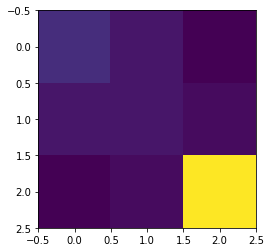

In [43]:
# plot sigma
plt.imshow(sigma, interpolation='nearest')
plt.show()

In [44]:
budget = num_assets // 2  # set budget
penalty = num_assets      # set parameter to scale the budget penalty term

qubit_stk, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)

## NumPyMinimumEigensolver (as a classical reference)
Lets solve the problem. First classically...

We can now use the Operator we built above without regard to the specifics of how it was created. We set the algorithm for the NumPyMinimumEigensolver so we can have a classical reference. The problem is set for 'ising'. Backend is not required since this is computed classically not using quantum computation. The result is returned as recommended stocks.

In [45]:
##### Validate with NumPy Minimum Eigensolver
exact_eigensolver = NumPyMinimumEigensolver(qubit_stk)
result_npstk = exact_eigensolver.run()

#print_result(result_npstk)
#select_np, value_np = rec_stocks(result_npstk, 'Classical')

### Solution using QAOA

Quantum Approximate Optimization Algorithm (QAOA) applied to the stock data. This is a variational algorithm and it uses an internal variational form that is created based on the problem. This will create a recommendation of which stocks should be selected for this time period based on the QAOA algorithm.

In [46]:
seed = np.random.seed(55)
optimizer = optim
optimizer.set_options(maxiter=5)
qaoa_qstk = QAOA(qubit_stk, optimizer)

qaoa_qstk.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                                   coupling_map=coup_map, noise_model=noise_mod)

result_qstk = qaoa_qstk.run(quantum_instance)

## Solution using VQE
Now we use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used. Provides recommendations for best stocks for this time period.

In [47]:
seed = np.random.seed(50)
optimizer = optim
optimizer.set_options(maxiter=5)
ry = TwoLocal(qubit_stk.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubit_stk, ry, optimizer)
vqe.randomrr_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                                   coupling_map=coup_map, noise_model=noise_mod)

result_vqe = vqe.run(quantum_instance)

#print_result(result_vqe)
#select_vqe, value_vqe = rec_stocks(result_vqe, 'VQE')

### Results


Recommendations for Classical Algorithm
-------------------------------------------------------
Classical Optimal value -0.0397

----------------- Classical Stocks Selected ---------------------
GME
---------------------------------------------------
 
Recommendations for QAOA
-------------------------------------------------------
QAOA performs worse to classical computer algorithm with value = -0.0020

----------------- QAOA Stocks Selected ---------------------
TLSA
---------------------------------------------------
 
Recommendations for VQE
-------------------------------------------------------
VQE performs worse than classical computer algorithm with value = 2.9495

----------------- VQE Stocks Selected ---------------------
TLSA
GME
---------------------------------------------------
 
Stock Price at Closing by Date for Selected Stocks


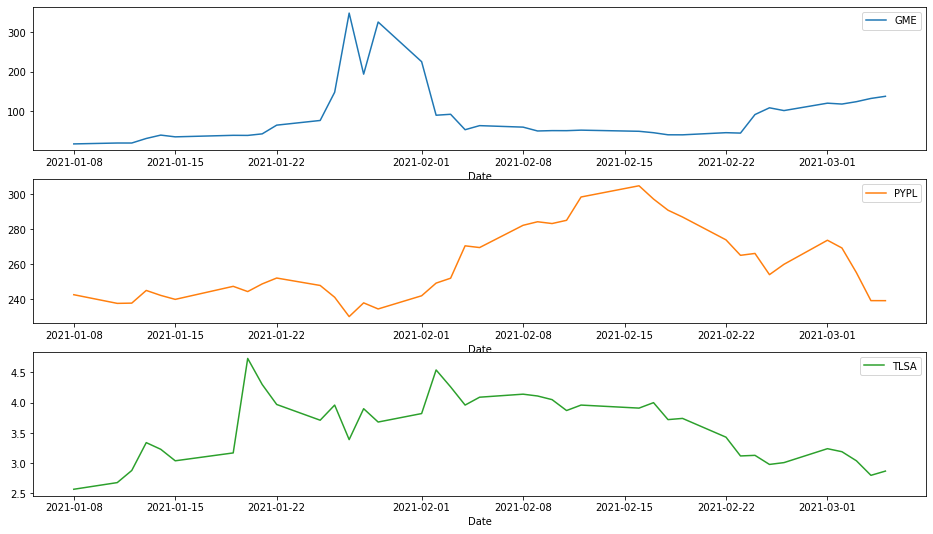

In [48]:
rec_stocks_class(result_npstk, result_qstk, result_vqe)
stockgraph()

## Methodology and Algorithm

The  mean-variance portfolio optimization problem for $n$ assets is defined as:

$\begin{aligned}
\min_{x \in \{0, 1\}^n}  q x^T \Sigma x - \mu^T x\\
\text{subject to: } 1^T x = B
\end{aligned}$

where we use the following notation:

- $x \in \{0, 1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i] = 1$) and which not to pick ($x[i] = 0$),
- $\mu \in \mathbb{R}^n$ defines the expected returns for the assets,
- $\Sigma \in \mathbb{R}^{n \times n}$ specifies the covariances between the assets,
- $q > 0$ controls the risk appetite of the decision maker,
- and $B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

We assume the following simplifications:
- all assets have the same price (normalized to 1),
- the full budget $B$ has to be spent, i.e. one has to select exactly $B$ assets.

The equality constraint $1^T x = B$ is mapped to a penalty term $(1^T x - B)^2$ which is scaled by a parameter and subtracted from the objective function. 
The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to  the optimal solution.
This notebook shows how to use the Variational Quantum Eigensolver (VQE) or the Quantum Approximate Optimization Algorithm (QAOA) to find the optimal solution for a given set of parameters.

Experiments on real quantum hardware for this problem are reported for instance in the following paper:
<br>
<a href="https://arxiv.org/abs/1907.04769">Improving Variational Quantum Optimization using CVaR. Barkoutsos et al. 2019.</a>

## References 
Add references later